In [18]:
import pandas as pd
import bayesian_pdes as bpdes
import sympy as sp
import numpy as np
import GPy, GPyOpt
import scipy, scipy.spatial
import matplotlib.pyplot as plt
import gpanim
import bayesian_design as bd
%matplotlib inline

In [19]:
x,y = sp.symbols('x y')
length_scale = 0.5
k = sp.exp(-(x-y)**2 / (2*length_scale)**2)
def A(f): return f.diff(x,x)
def Abar(f): return f.diff(y,y)
def Identity(f): return f

ops = [A, Identity]
ops_bar = [Abar, Identity]

bdy_locs = np.array([[0.], [1.]])
bdy_values = np.array([[0.], [0.]])
bdy_obs = (bdy_locs, bdy_values)

In [20]:
op_cache = bpdes.generate_op_cache(ops, ops_bar, k, [[x], [y]], mode='compile')

In [21]:
obs_locations = np.linspace(0,1,6)[1:-1, None]
def rhs(pts):
    return np.sin(2*np.pi*pts)
obs_values = rhs(obs_locations)

indexer = np.arange(len(obs_locations))
orig_locations = obs_locations.copy()
orig_values = obs_values.copy()
orig_posterior = bpdes.collocate(ops, ops_bar, k, [[x], [y]], [(orig_locations, orig_values), bdy_obs], op_cache)

**Deletion function** 

In the terminology of Meyer & Nachtsheim we are using a linear design (i.e. $L(D) = tr(D)$, where D is my variance-covariance matrix). Then following their terminology my deletion function ought to be:

$$
d_L(x_i) = \frac{\phi(x_i)}{1-v(x_i)} \\
\phi(x_i) = L(D f(x_i) f(x_i)^T D) \\
v(x_i) = f(x_i) D f(x_i)^T
$$

Now then the question becomes - who is this $f$ and what does he have to do with anything? It seems that $f$ is like a feature function? i.e. $f^T(x_i)$ is supposed to be the $i$-th row of the design matrix. So am I worrying about nothing? i.e. $\phi = trace(\Sigma)$, $v(x_i) = \Sigma_{ii}$? 

In [22]:
from IPython.display import display
def plot_gp(x, mu, cov):
    anim = gpanim.animate_gp(x, mu, cov, samples=10, plot_kwargs={'alpha': 0.5, 'c': 'gray'})
    plt.plot(x, mu, c='lime', linewidth=2)    
    display(anim)

In [23]:

def deletion(points, loss):
    base_loss = loss(points)
    indices = np.arange(len(points))
    new_losses = np.empty(points.shape[0])
    for i in indices:
        flags = indices != i
        new_losses[i] = loss(points[flags])

    return new_losses, base_loss

def numpy_to_scipy_bounds(b):
    # degenerate 1D case
    if len(b.shape) == 1 and b.shape[0] == 2:
        return [(b[0], b[1])]
    else:
        return [(b[i,0], b[i, 1]) for i in range(b.shape[0])]

# todo: can include the GRADIENT of the GP for a better optimization!
def ace(initial_design, k, max_iter, loss_fn, emulator, emu_design_space, optim_bounds, debug=False):
    # initial_design should have shape 2; else reshape it
    if len(initial_design.shape) == 1:
        initial_design = initial_design[:,None]
    if len(initial_design.shape) > 2:
        raise Exception("Initial design should be a 2D array, with one row per point and one column per dimension.")
    
    cur_design = initial_design.copy()
    cur_loss = loss_fn(cur_design)
    for ix in xrange(max_iter):
        losses, base_loss = deletion(cur_design, loss_fn)
        #print losses - base_loss
        points_to_modify = np.argsort(losses-base_loss)[:k]
        for i in points_to_modify:
            cur_point = cur_design[i,:]
            # dump out the point we are modifying
            index_mask = indexer != i
            D_i = cur_design[index_mask, :]
            
            # proxy for the loss function, as a function of the point we are modifying
            def __L(d):
                tmp_D_i = np.atleast_2d(np.append(D_i, d)).T
                return loss_fn(tmp_D_i)
            __L = np.vectorize(__L)

            # generate the bounds for the adjustment
            # this has to be limited since the domain is limited, but also gives us the option
            # to limit to a subset of the domain
            # TODO: what if we are not in a 1D domain?
            if type(optim_bounds) is np.ndarray:
                sp_bounds = numpy_to_scipy_bounds(optim_bounds)
            elif type(optim_bounds) is list:
                sp_bounds = optim_bounds # no requirement here
            elif callable(optim_bounds):
                sp_bounds = optim_bounds(cur_point)
                if type(sp_bounds) is np.ndarray:
                    sp_bounds = numpy_to_scipy_bounds(sp_bounds)
            else:
                raise Exception('Optimizer bounds must be either an array of global bounds or a function for local bounds.')

            # estimate the loss function at some locations (so that we can emulate it)
            locations = emu_design_space(cur_point)
            losses = __L(locations)

            # construct the emulator
            loss_emulator = emulator(locations, losses)

            # now solve the optimization problem.
            # Note there are some issues here - firstly a scale problem, since we are typically working with 
            # loss functions which take very small values, which screws with the optimizer.
            # secondly - we could definitely supply the gradient here, and we definitely should!!
            new_point = scipy.optimize.minimize(lambda x: 1e16*loss_emulator(x), cur_point, bounds=sp_bounds)

            # now decide whether to _use_ that point.
            # In Overstall & Woods we have an acceptance probability for the proposal which is not included here.
            # This is because our loss function is exact (it is the trace of posterior covariance) so we can just look
            # at whether the new location is a better design than the old one, rather than looking at probabilities.
            new_loss = __L(new_point.x)[0]
            if new_loss < cur_loss:
                cur_loss = new_loss
                print ix, "Moved {} from {} to {} (new loss {:.2e} > {:.2e}. Emulator value is {:.2e})".format(i, cur_point, new_point.x, new_loss, cur_loss, new_point.fun[0,0])
                cur_design[i, :] = new_point.x
            else:
                print ix, "Rejected move of {} from {} to {}, (new loss {:.2e} > {:.2e}. Emulator value is {:.2e})".format(i, cur_point, new_point.x, new_loss, cur_loss, new_point.fun[0,0])
    return cur_design

In [24]:
test_space = np.linspace(0,1,11)[1:-1,None] # test space for optimality criterion (i.e. points to take covariance trace at)
adjust_domain = 1.0
emu_length_scale = 0.1
emu_design_points = 20

def design_space(d):
    bounds = get_optimizer_bounds(d)
    return np.random.uniform(bounds[0][0], bounds[0][1], emu_design_points)[:,None]

# todo: significantly more efficient to use a moore-penrose inverse here but a bit complicated...
def get_cov(points):
    obs = rhs(points)
    posterior = bpdes.collocate(ops, ops_bar, k, [[x], [y]], [(points, obs), bdy_obs], op_cache)
    _,cov = posterior(test_space)
    return cov

def get_optimizer_bounds(point):
    return [(max(point-adjust_domain, 0.), min(point+adjust_domain, 1.))]

def random_gp_emulator(length_scale, input_dim, design_fn, loss):
    import GPy

    def gpy_emulator(bounds):
        inputs = design_fn(bounds)
        values = np.array([[loss(inputs[i, :])] for i in xrange(inputs.shape[0])])

        model = GPy.models.GPRegression(inputs, values, GPy.kern.RBF(input_dim=input_dim, lengthscale=length_scale))
        return lambda x: model.predict(np.atleast_2d(x))[0]
    return gpy_emulator

debug_plots=False
def gpyopt_optimizer(function, cur_point, other_points):
    bounds = get_optimizer_bounds(cur_point)
    opt = GPyOpt.methods.BayesianOptimization(function, bounds, X=np.array([cur_point]))
    opt.run_optimization()
    
    if debug_plots:
        opt.plot_convergence()
        plt.axvline(opt.x_opt, c='green')
        plt.axvline(cur_point, c='red')
        plt.scatter(other_points, np.ones_like(other_points), c='black')

        plt.show()
        plt.close()
    return opt.x_opt

loss = bd.a_optimality(get_cov)
optimal_design = bd.ace(
    obs_locations, 
    1, 
    10, 
    loss, 
    gpyopt_optimizer,  
    True
)

*Optimization completed:
   -Maximum number of iterations reached.
0 Moved 1 from [ 0.4] to [ 0.5507907] (new loss 5.63e-13 < 2.86e-12)
*Optimization completed:
   -Maximum number of iterations reached.
1 Rejected move of 2 from [ 0.6] to [ 0.59441388], (new loss 5.64e-13 > 5.63e-13)
*Optimization completed:
   -Maximum number of iterations reached.
2 Rejected move of 2 from [ 0.6] to [ 0.58640409], (new loss 5.66e-13 > 5.63e-13)
*Optimization completed:
   -Maximum number of iterations reached.
3 Rejected move of 2 from [ 0.6] to [ 0.59870127], (new loss 5.63e-13 > 5.63e-13)
*Optimization completed:
   -Maximum number of iterations reached.
4 Rejected move of 2 from [ 0.6] to [ 0.54804202], (new loss 5.98e-13 > 5.63e-13)
*Optimization completed:
   -Maximum number of iterations reached.
5 Rejected move of 2 from [ 0.6] to [ 0.5227448], (new loss 6.38e-13 > 5.63e-13)
*Optimization completed:
   -Maximum number of iterations reached.
6 Rejected move of 2 from [ 0.6] to [ 0.61126664], (n

In [25]:
optimal_obs = rhs(optimal_design)
posterior = bpdes.collocate(ops, ops_bar, k, [[x], [y]], [(optimal_design, optimal_obs), bdy_obs], op_cache)

(0, 1)

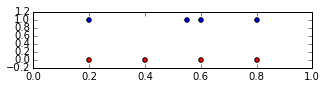

In [26]:
plt.figure(figsize=(5,1))
plt.scatter(optimal_design, np.ones_like(optimal_design))
plt.scatter(orig_locations, np.zeros_like(orig_locations), c='r')
plt.xlim(0,1)

In [29]:
from IPython.display import display
samples = 20
plt.figure(figsize=(10,3))
test_points = np.linspace(0,1,101)[:, None]
mu, cov = posterior(test_points)
#plt.plot(test_points, np.random.multivariate_normal(mu.ravel(),cov,500).T, c='gray', alpha=0.1)
a = gpanim.animate_gp(test_points, mu, cov, samples=samples, plot_kwargs={'c': 'gray', 'alpha': 0.5})
for obs in optimal_design:
    plt.axvline(obs, linestyle='--', c='gray')
plt.plot(test_points, mu, c='lime', alpha=0.5)
plt.plot(test_points, -np.sin(2*np.pi*test_points) / (4*np.pi**2), c='red')
plt.title('Optimal (L={:.2E})'.format(np.sum(np.diag(cov)**2)))
display(a)

plt.figure(figsize=(10,3))
mu, cov = orig_posterior(test_points)
#plt.plot(test_points, np.random.multivariate_normal(mu.ravel(),cov,500).T, c='gray', alpha=0.1)
a = gpanim.animate_gp(test_points, mu, cov, samples=samples, plot_kwargs={'c': 'gray', 'alpha': 0.5})
for obs in orig_locations:
    plt.axvline(obs, linestyle='--', c='gray')
plt.plot(test_points, mu, c='lime', alpha=0.5)
plt.plot(test_points, -np.sin(2*np.pi*test_points) / (4*np.pi**2), c='red')
plt.title('Original (L={:.2E})'.format(np.sum(np.diag(cov)**2)))
display(a)

In [28]:
optimal_design

array([[ 0.2      ],
       [ 0.5507907],
       [ 0.6      ],
       [ 0.8      ]])